In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 64,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_1 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(gru)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features_2 = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = concatenate([pooled_features_1, pooled_features_2])
pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21184/102124 [=====>........................] - ETA: 9:03 - loss: 0.1190 - acc: 0.9587

 68608/102124 [===================>..........] - ETA: 3:40 - loss: 0.0803 - acc: 0.9718

102124/102124 [==============================] - 725s 7ms/step - loss: 0.0726 - acc: 0.9743 - val_loss: 0.0501 - val_acc: 0.9815
Epoch 2/32
   992/102124 [..............................] - ETA: 11:10 - loss: 0.0572 - acc: 0.9798

 37408/102124 [=========>....................] - ETA: 7:01 - loss: 0.0527 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9809

102124/102124 [==============================] - 723s 7ms/step - loss: 0.0517 - acc: 0.9809 - val_loss: 0.0471 - val_acc: 0.9828
roc-auc: 0.9851 - roc-auc_val: 0.9823                                                                                                    
Epoch 3/32
  8640/102124 [=>............................] - ETA: 10:08 - loss: 0.0517 - acc: 0.9803

 48576/102124 [=============>................] - ETA: 5:48 - loss: 0.0484 - acc: 0.9817

 96640/102124 [===========================>..] - ETA: 35s - loss: 0.0482 - acc: 0.9817

102124/102124 [==============================] - 721s 7ms/step - loss: 0.0481 - acc: 0.9817 - val_loss: 0.0429 - val_acc: 0.9838
Epoch 4/32
 11808/102124 [==>...........................] - ETA: 9:47 - loss: 0.0469 - acc: 0.9822

 56960/102124 [===============>..............] - ETA: 4:54 - loss: 0.0462 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9826

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0455 - acc: 0.9826 - val_loss: 0.0468 - val_acc: 0.9819
roc-auc: 0.9902 - roc-auc_val: 0.9871                                                                                                    
Epoch 5/32
  8640/102124 [=>............................] - ETA: 10:09 - loss: 0.0449 - acc: 0.9823

 52768/102124 [==============>...............] - ETA: 5:21 - loss: 0.0438 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9829

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0439 - acc: 0.9829 - val_loss: 0.0412 - val_acc: 0.9841
Epoch 6/32
 10112/102124 [=>............................] - ETA: 9:59 - loss: 0.0453 - acc: 0.9822 

 49664/102124 [=============>................] - ETA: 5:41 - loss: 0.0431 - acc: 0.9832

 99488/102124 [============================>.] - ETA: 17s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0421 - val_acc: 0.9841
roc-auc: 0.9917 - roc-auc_val: 0.9878                                                                                                    
Epoch 7/32
  8096/102124 [=>............................] - ETA: 10:11 - loss: 0.0414 - acc: 0.9835

 53760/102124 [==============>...............] - ETA: 5:14 - loss: 0.0408 - acc: 0.9842

100224/102124 [============================>.] - ETA: 12s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0413 - acc: 0.9839 - val_loss: 0.0453 - val_acc: 0.9828

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002679433673620224.
Epoch 8/32
  9728/102124 [=>............................] - ETA: 10:02 - loss: 0.0392 - acc: 0.9845

 49664/102124 [=============>................] - ETA: 5:41 - loss: 0.0405 - acc: 0.9842

 99200/102124 [============================>.] - ETA: 19s - loss: 0.0402 - acc: 0.9842

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0409 - val_acc: 0.9843
roc-auc: 0.9929 - roc-auc_val: 0.9887                                                                                                    
Epoch 9/32
  7872/102124 [=>............................] - ETA: 10:15 - loss: 0.0406 - acc: 0.9843

 48576/102124 [=============>................] - ETA: 5:48 - loss: 0.0395 - acc: 0.9845

 90624/102124 [=========================>....] - ETA: 1:14 - loss: 0.0392 - acc: 0.9846

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0393 - acc: 0.9845 - val_loss: 0.0450 - val_acc: 0.9835
Epoch 10/32
  9504/102124 [=>............................] - ETA: 10:03 - loss: 0.0389 - acc: 0.9844

 46976/102124 [============>.................] - ETA: 5:59 - loss: 0.0382 - acc: 0.9847

 93824/102124 [==========================>...] - ETA: 54s - loss: 0.0383 - acc: 0.9847

102124/102124 [==============================] - 719s 7ms/step - loss: 0.0384 - acc: 0.9847 - val_loss: 0.0433 - val_acc: 0.9839
roc-auc: 0.9934 - roc-auc_val: 0.9878                                                                                                    
Epoch 11/32
  6720/102124 [>.............................] - ETA: 10:22 - loss: 0.0367 - acc: 0.9854

 56544/102124 [===============>..............] - ETA: 4:57 - loss: 0.0366 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9850

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0377 - acc: 0.9850 - val_loss: 0.0424 - val_acc: 0.9838
Epoch 12/32
 10112/102124 [=>............................] - ETA: 9:59 - loss: 0.0386 - acc: 0.9850

 68256/102124 [===================>..........] - ETA: 3:40 - loss: 0.0371 - acc: 0.9851

102124/102124 [==============================] - 720s 7ms/step - loss: 0.0373 - acc: 0.9851 - val_loss: 0.0430 - val_acc: 0.9838
roc-auc: 0.9943 - roc-auc_val: 0.9886                                                                                                    
Epoch 13/32
   576/102124 [..............................] - ETA: 11:09 - loss: 0.0274 - acc: 0.9887

 44736/102124 [============>.................] - ETA: 6:15 - loss: 0.0362 - acc: 0.9857

 82272/102124 [=======================>......] - ETA: 2:10 - loss: 0.0367 - acc: 0.9855

102124/102124 [==============================] - 724s 7ms/step - loss: 0.0367 - acc: 0.9856 - val_loss: 0.0412 - val_acc: 0.9841
Epoch 14/32
  6336/102124 [>.............................] - ETA: 10:26 - loss: 0.0345 - acc: 0.9854

 43104/102124 [===========>..................] - ETA: 6:26 - loss: 0.0353 - acc: 0.9861

 82688/102124 [=======================>......] - ETA: 2:07 - loss: 0.0362 - acc: 0.9856

102124/102124 [==============================] - 724s 7ms/step - loss: 0.0360 - acc: 0.9856 - val_loss: 0.0416 - val_acc: 0.9844
roc-auc: 0.9948 - roc-auc_val: 0.9884                                                                                                    
Epoch 15/32
  4000/102124 [>.............................] - ETA: 10:38 - loss: 0.0369 - acc: 0.9861

 54784/102124 [===============>..............] - ETA: 5:10 - loss: 0.0359 - acc: 0.9858

 92704/102124 [==========================>...] - ETA: 1:01 - loss: 0.0358 - acc: 0.9858

102124/102124 [==============================] - 724s 7ms/step - loss: 0.0357 - acc: 0.9858 - val_loss: 0.0431 - val_acc: 0.9840
Epoch 16/32
 10304/102124 [==>...........................] - ETA: 9:57 - loss: 0.0351 - acc: 0.9862

 57824/102124 [===============>..............] - ETA: 4:48 - loss: 0.0350 - acc: 0.9860

100416/102124 [============================>.] - ETA: 11s - loss: 0.0352 - acc: 0.9860

102124/102124 [==============================] - 722s 7ms/step - loss: 0.0352 - acc: 0.9860 - val_loss: 0.0439 - val_acc: 0.9838
roc-auc: 0.9952 - roc-auc_val: 0.9878                                                                                                    
Epoch 17/32
  8224/102124 [=>............................] - ETA: 10:12 - loss: 0.0338 - acc: 0.9871

 46976/102124 [============>.................] - ETA: 6:00 - loss: 0.0342 - acc: 0.9866

 86688/102124 [========================>.....] - ETA: 1:40 - loss: 0.0342 - acc: 0.9865

102124/102124 [==============================] - 721s 7ms/step - loss: 0.0344 - acc: 0.9864 - val_loss: 0.0412 - val_acc: 0.9844
Epoch 18/32
  8064/102124 [=>............................] - ETA: 10:14 - loss: 0.0362 - acc: 0.9853

 63264/102124 [=================>............] - ETA: 4:13 - loss: 0.0346 - acc: 0.9861

102112/102124 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9863

102124/102124 [==============================] - 721s 7ms/step - loss: 0.0342 - acc: 0.9863 - val_loss: 0.0434 - val_acc: 0.9842

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9955 - roc-auc_val: 0.9886                                                                                                    


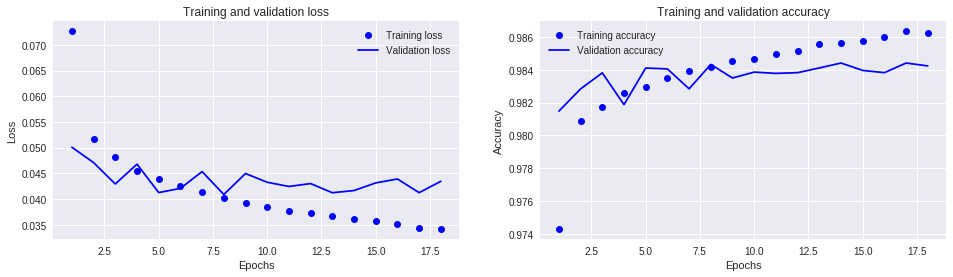

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 75s 2ms/step
([0.041302617912805345, 0.9850644813050078], 0.990600139552178)
